<a href="https://colab.research.google.com/github/Andreyka452/4M_heat_rod/blob/master/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np              # Массивы (матрицы, векторы, линейная алгебра)
import matplotlib.pyplot as plt # Научная графика
%matplotlib inline 
    # Говорим jupyter'у, чтобы весь графический вывод был в браузере, а не в отдельном окне
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения

## Описание, визуализация.

In [3]:
data = pd.read_csv('/content/drive/My Drive/file/vehicles_full.csv')

Здесь представлен набор данных поддержанных автомобилей. 
Необходимо в зависимости от параметров определить состояние автомобиля. (Excellent, good, like new, fair, new, salvage). В данном наборе данных представлены следующие признаки:
id, url, vin,  region, region_url, price year, manufacturer, model,  condition,  cylinders,  fuel, odometer, title_status, transmission, vin,  drive,  size, type, paint_color,  image_url,  description,  county, state,  lat,  long.
Характеристики, которые не влияют на состояние (id), сложно интерпритировь (url, description), дублируются (region_url - region). Также в характеристике модель :14284 уникальных значений и при бинаризации не хватает памяти, но есть характеристика марка – manufacturer, марка и модель на прямую зависят друг от друга. В характеристике марка – 42 уникальных значения, поэтому будем считать, что у каждой марки одинаковое качество сборки для всех моделей и характеристику модель мы тоже исключим для экономии памяти.
В county нет ни одного заполненного значения, удалим его тоже.
Итого, следующие характеристики будут исключены:
id, url,  region_url, description, image_url, model,  county.



In [4]:
data.shape

(423857, 25)

Данных очень много : На полных данных метод k-ближайшего соседа выполняется около 3-х часов и сессии в Google Colaboratory не хватает на проведение всех экспериментов. Поэтому будем брать случайную выборку из 10000 автомобилей.



In [5]:
data = data.sample(10000)

In [6]:
data.sample(10)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,county,state,lat,long
99799,7193100078,https://porthuron.craigslist.org/ctd/d/chesani...,port huron,https://porthuron.craigslist.org,1995,2006.0,buick,terraza,NaN,NaN,gas,171243.0,clean,automatic,5GADV33136D147408,NaN,NaN,NaN,NaN,https://images.craigslist.org/01414_d2Nfm8s3cX...,WE HAVE OVER 500 VEHICLES IN STOCK! See our ...,NaN,mi,43.1824,-84.1122
170900,7196879431,https://wyoming.craigslist.org/ctd/d/cheyenne-...,logan,https://logan.craigslist.org,13999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ut,NaN,NaN
67795,7196772769,https://washingtondc.craigslist.org/mld/ctd/d/...,"washington, DC",https://washingtondc.craigslist.org,33500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dc,NaN,NaN
290622,7186773302,https://amarillo.craigslist.org/ctd/d/amarillo...,amarillo,https://amarillo.craigslist.org,6700,2011.0,kia,forte,excellent,4 cylinders,gas,101528.0,clean,automatic,KNAFW6A34B5437815,fwd,NaN,coupe,black,https://images.craigslist.org/00L0L_6QuLbnlr8b...,2011 *** KIA FORTE SX Coupe *** Ready To Up...,NaN,tx,35.2166,-101.8300
119932,7178371369,https://savannah.craigslist.org/ctd/d/hinesvil...,savannah / hinesville,https://savannah.craigslist.org,0,2016.0,dodge,charger,NaN,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,sedan,NaN,https://images.craigslist.org/00L0L_37jQSgjkcG...,## WE ARE ALL ABOUT SECOND CHANCES!!! #All Mak...,NaN,ga,31.8513,-81.6072
161758,7196948200,https://easttexas.craigslist.org/cto/d/canton-...,deep east texas,https://nacogdoches.craigslist.org,3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx,NaN,NaN
170616,7189232914,https://chico.craigslist.org/ctd/d/petaluma-20...,chico,https://chico.craigslist.org,25995,2007.0,toyota,tacoma,NaN,NaN,gas,81549.0,clean,automatic,5TEMU52N37Z439988,4wd,NaN,pickup,white,https://images.craigslist.org/00d0d_gTw7Ce7XmM...,2007 Toyota Tacoma Double Cab Long Bed V6 Auto...,NaN,ca,38.2277,-122.6190
145835,7195985326,https://portland.craigslist.org/wsc/ctd/d/hill...,portland,https://portland.craigslist.org,14000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,or,NaN,NaN
218971,7194461027,https://stlouis.craigslist.org/ctd/d/saint-lou...,"st louis, MO",https://stlouis.craigslist.org,0,2006.0,ford,f-250,NaN,NaN,diesel,162004.0,clean,NaN,1FTSW21P76EC64939,4wd,NaN,pickup,red,https://images.craigslist.org/00Z0Z_fLnAPAfdjy...,2006 Ford F-250SD Offered by: Rock Road Au...,NaN,il,38.7170,-90.3626
383097,7180490459,https://wenatchee.craigslist.org/cto/d/wenatch...,wenatchee,https://wenatchee.craigslist.org,5200,2008.0,honda,cr-v,excellent,6 cylinders,gas,260000.0,clean,automatic,NaN,4wd,compact,SUV,brown,https://images.craigslist.org/00D0D_4wBZF6b2B5...,En excelentes condiciones! Llama para ir a ver...,NaN,wa,47.4129,-120.3030


In [7]:
del data['county']
del data['url']
del data['region_url']
del data['vin']
del data['image_url']
del data['description']
del data['id']
del data['model']
del data['title_status']
del data['paint_color']
del data['state']
del data['region']
del data['size']
del data['type']
del data['lat']
del data['long']

In [8]:
data_copy = data.copy()

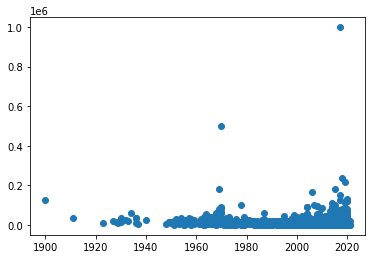

In [9]:
plt.scatter(data_copy['year'], data_copy['price'])
pass

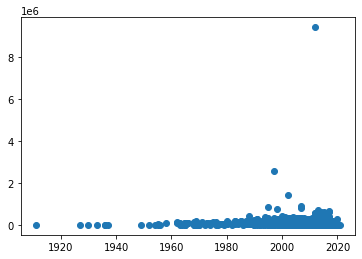

In [10]:
plt.scatter(data_copy['year'], data_copy['odometer'])
pass

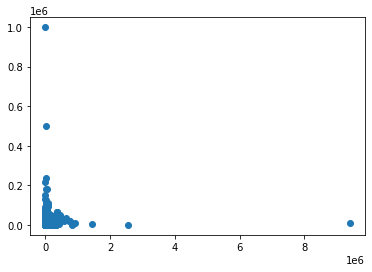

In [11]:
plt.scatter(data_copy['odometer'], data_copy['price'])
pass

### Борьба с выбросами.

In [12]:
data_copy['price'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005        0.000
0.010        0.000
0.050        0.000
0.100      495.900
0.500     9995.000
0.900    30243.700
0.950    38970.500
0.990    59999.000
0.995    70004.975
Name: price, dtype: float64

In [13]:
data_copy['year'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005    1956.98
0.010    1966.00
0.050    1996.00
0.100    2002.00
0.500    2012.00
0.900    2018.00
0.950    2019.00
0.990    2020.00
0.995    2020.00
Name: year, dtype: float64

In [14]:
data_copy['odometer'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005         0.00
0.010        10.00
0.050     10230.20
0.100     19889.00
0.500     92874.00
0.900    180000.00
0.950    205186.10
0.990    286503.25
0.995    341118.00
Name: odometer, dtype: float64

Оставим самые популярные по цене, пробегу и году выпуска.

In [15]:
rows_to_drop = data_copy[
    (data_copy['price'] == 0) |
    (data_copy['price'] < data_copy['price'].quantile(0.005)) | (data_copy['price'] > data_copy['price'].quantile(0.995)) | 
    (data_copy['year'] < data_copy['year'].quantile(0.005)) | (data_copy['year'] > data_copy['year'].quantile(0.995)) |
    (data_copy['odometer']  < data_copy['odometer' ].quantile(0.005)) | (data_copy['odometer']  > data_copy['odometer' ].quantile(0.995))].index
data_itog = data_copy.drop(rows_to_drop)
data_itog.shape

(9080, 9)

In [16]:
data_itog.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9080 entries, 9103 to 21495
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         9080 non-null   int64  
 1   year          7056 non-null   float64
 2   manufacturer  6733 non-null   object 
 3   condition     3933 non-null   object 
 4   cylinders     4425 non-null   object 
 5   fuel          7035 non-null   object 
 6   odometer      5881 non-null   float64
 7   transmission  7049 non-null   object 
 8   drive         5094 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 3.0 MB


In [17]:
data_obj = data_itog.select_dtypes(include=['object']).copy()
data_obj.describe()

,manufacturer,condition,cylinders,fuel,transmission,drive
count,6733,3933,4425,7035,7049,5094
unique,38,6,8,5,3,3
top,ford,excellent,4 cylinders,gas,automatic,4wd
freq,1283,1891,1603,6260,6268,2115


In [18]:
converted_obj = pd.DataFrame()

for col in data_itog.columns:
    if ((col != 'region_url') & (col != 'price') & (col != 'year') & (col != 'odometer') & (col != 'lat') & (col != 'long') & (col != 'vin')):
        num_unique_values = len(data_itog[col].unique())
        num_total_values = len(data_itog[col])
        if num_unique_values / num_total_values < 0.5:
            converted_obj.loc[:,col] = data_itog[col].astype('category')
        else:
            converted_obj.loc[:,col] = data_itog[col]
    else:
        converted_obj.loc[:,col] = data_itog[col]

In [19]:
converted_obj.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9080 entries, 9103 to 21495
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   price         9080 non-null   int64   
 1   year          7056 non-null   float64 
 2   manufacturer  6733 non-null   category
 3   condition     3933 non-null   category
 4   cylinders     4425 non-null   category
 5   fuel          7035 non-null   category
 6   odometer      5881 non-null   float64 
 7   transmission  7049 non-null   category
 8   drive         5094 non-null   category
dtypes: category(6), float64(2), int64(1)
memory usage: 342.9 KB


In [20]:
converted_obj.describe(include=['category'])

,manufacturer,condition,cylinders,fuel,transmission,drive
count,6733,3933,4425,7035,7049,5094
unique,38,6,8,5,3,3
top,ford,excellent,4 cylinders,gas,automatic,4wd
freq,1283,1891,1603,6260,6268,2115


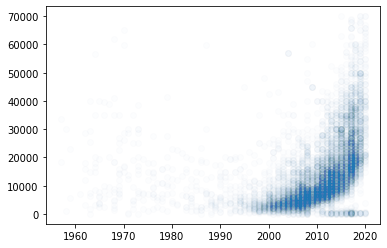

In [21]:
plt.scatter(converted_obj['year'], converted_obj['price'], alpha=0.01)
pass

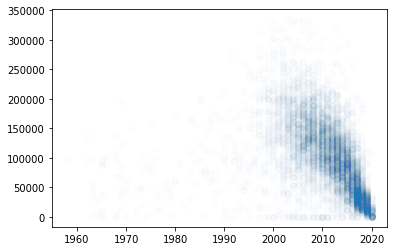

In [22]:
plt.scatter(converted_obj['year'], converted_obj['odometer'], alpha=0.01)
pass

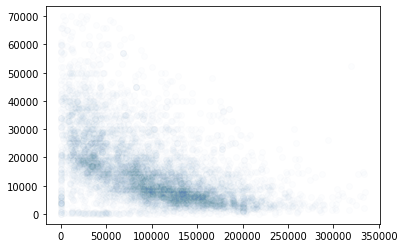

In [23]:
plt.scatter(converted_obj['odometer'], converted_obj['price'], alpha=0.01)
pass

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


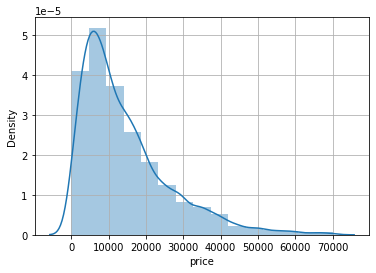

In [24]:
sns.distplot(converted_obj['price'], bins=15)
plt.grid()
pass

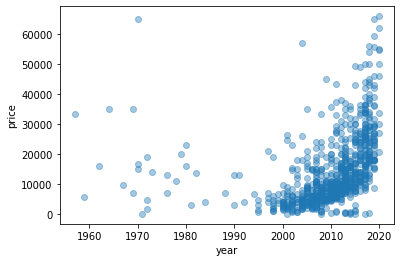

In [25]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(converted_obj.shape[0]), size=1000, replace=False)
plt.scatter(converted_obj.iloc[random_subset]['year'], converted_obj.iloc[random_subset]['price'], alpha=0.4)
plt.xlabel('year')
plt.ylabel('price')
pass

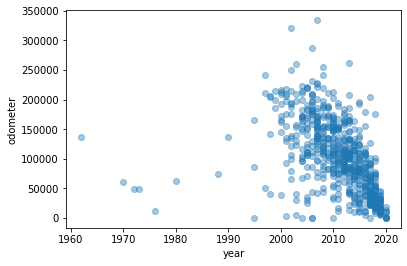

In [26]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(converted_obj.shape[0]), size=1000, replace=False)
plt.scatter(converted_obj.iloc[random_subset]['year'], converted_obj.iloc[random_subset]['odometer'], alpha=0.4)
plt.xlabel('year')
plt.ylabel('odometer')
pass

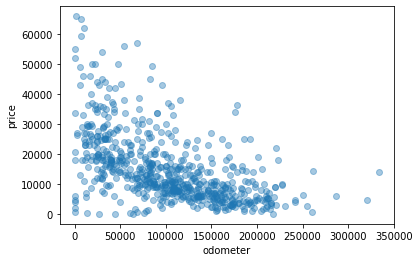

In [27]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(converted_obj.shape[0]), size=1000, replace=False)
plt.scatter(converted_obj.iloc[random_subset]['odometer'], converted_obj.iloc[random_subset]['price'], alpha=0.4)
plt.xlabel('odometer')
plt.ylabel('price')
pass

In [28]:
plt.figure(figsize = (10, 8))
sns.scatterplot(x='year', y='price', size='size', hue='fuel', data=converted_obj.iloc[random_subset], alpha=0.7)
pass

ValueError: ignored

<Figure size 720x576 with 0 Axes>

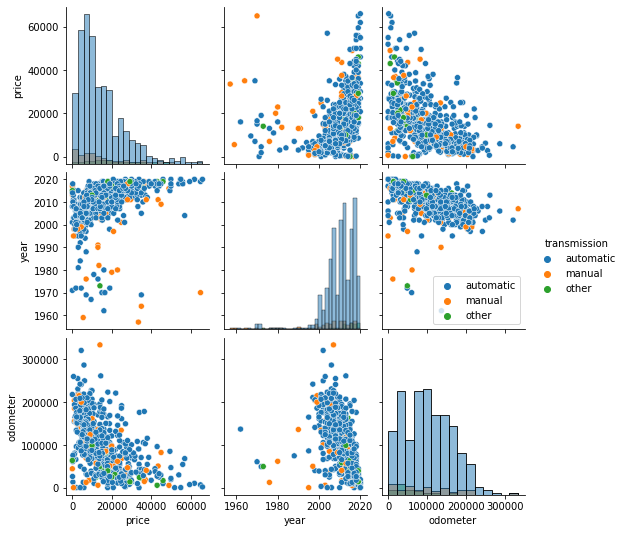

In [29]:
sns.pairplot(converted_obj.iloc[random_subset], hue='transmission', diag_kind='hist')
plt.legend()
pass

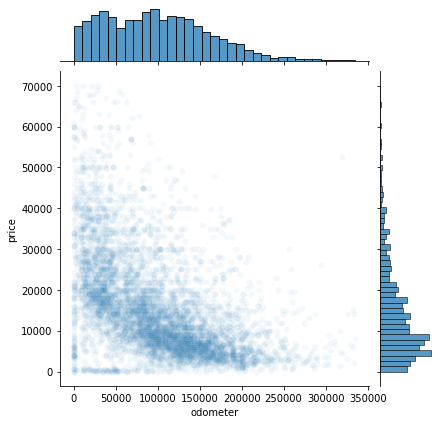

In [30]:
sns.jointplot(x='odometer', y='price', alpha=.05, data=converted_obj)
pass

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


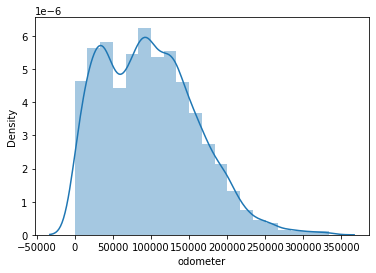

In [31]:
sns.distplot(converted_obj['odometer'], bins = 20)
pass

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


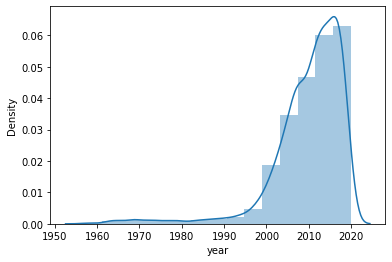

In [32]:
sns.distplot(converted_obj['year'], bins = 15)
pass

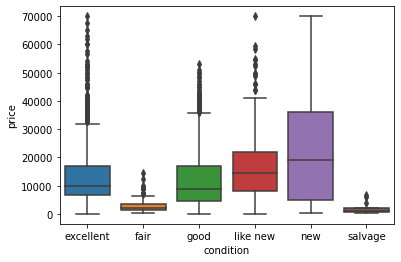

In [33]:
sns.boxplot(x="condition", y="price", data=converted_obj)
pass

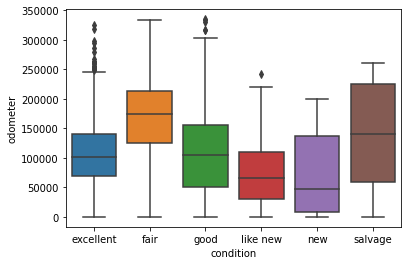

In [34]:
sns.boxplot(x="condition", y="odometer", data=converted_obj)
pass

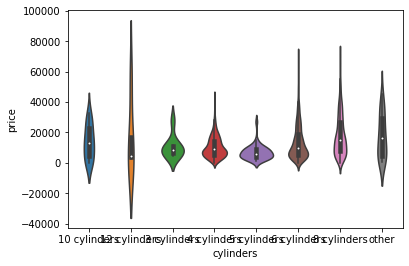

In [35]:
sns.violinplot(x="cylinders", y="price", data=converted_obj)
pass

In [36]:
corr_mat = converted_obj.corr()
corr_mat

,price,year,odometer
price,1.000000,0.367816,-0.510850
year,0.367816,1.000000,-0.427658
odometer,-0.510850,-0.427658,1.000000


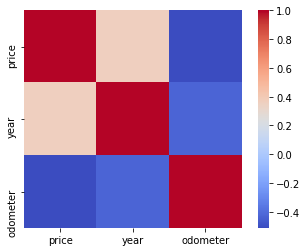

In [37]:
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

Самые сильные зависимости — это цена пробег и пробег, причём коррелляция отрицательная, что логично - чем больше пробег и год, тем меньше цена автомобиля.

In [38]:
corr_mat < -0.4

,price,year,odometer
price,False,False,True
year,False,False,True
odometer,True,True,False


In [39]:
corr_mat.where(np.triu(corr_mat < -0.4, k=1)).stack().sort_values(ascending=False)

year   odometer   -0.427658
price  odometer   -0.510850
dtype: float64

In [40]:
converted_obj['cylinders'].unique()

['6 cylinders', NaN, '8 cylinders', '4 cylinders', '5 cylinders', '10 cylinders', 'other', '3 cylinders', '12 cylinders']
Categories (8, object): ['6 cylinders', '8 cylinders', '4 cylinders', '5 cylinders', '10 cylinders',
                         'other', '3 cylinders', '12 cylinders']

In [42]:
data['cylinders'].value_counts()

4 cylinders     1711
6 cylinders     1685
8 cylinders     1292
5 cylinders       40
other             26
10 cylinders      17
3 cylinders        8
12 cylinders       5
Name: cylinders, dtype: int64

Белый цвет не выгорает, значит состояние автомобиля не сильно изменяется со временем. Поэтому люди стараются купить белый автомобиль что-бы его покрытие дольше сохраняло товарный вид.

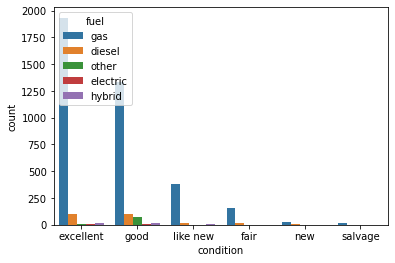

In [44]:
sns.countplot(x='condition', order=converted_obj['condition'].value_counts().index, hue='fuel', data=data)
pass

##Заполнение пропущенных значений 

In [45]:
converted_obj.isna().sum()

price              0
year            2024
manufacturer    2347
condition       5147
cylinders       4655
fuel            2045
odometer        3199
transmission    2031
drive           3986
dtype: int64

In [46]:
converted_obj.fillna(data.median(axis = 0), axis=0 , inplace=True)

In [47]:
converted_obj.isna().sum()

price              0
year               0
manufacturer    2347
condition       5147
cylinders       4655
fuel            2045
odometer           0
transmission    2031
drive           3986
dtype: int64

In [48]:
converted_obj['manufacturer'].fillna(data['manufacturer'].mode().iloc[0], inplace=True)
#converted_obj['model'].fillna(data['model'].mode().iloc[0], inplace=True)
converted_obj['condition'].fillna(data['condition'].mode().iloc[0], inplace=True)
converted_obj['cylinders'].fillna(data['cylinders'].mode().iloc[0], inplace=True)
converted_obj['fuel'].fillna(data['fuel'].mode().iloc[0], inplace=True)
#converted_obj['title_status'].fillna(data['title_status'].mode().iloc[0], inplace=True)
converted_obj['transmission'].fillna(data['transmission'].mode().iloc[0], inplace=True)
#converted_obj['vin'].fillna(data['vin'].mode().iloc[0], inplace=True)
converted_obj['drive'].fillna(data['drive'].mode().iloc[0], inplace=True)
#converted_obj['size'].fillna(data['size'].mode().iloc[0], inplace=True)
#converted_obj['type'].fillna(data['type'].mode().iloc[0], inplace=True)
#converted_obj['paint_color'].fillna(data['paint_color'].mode().iloc[0], inplace=True)
#converted_obj['image_url'].fillna(data['image_url'].mode().iloc[0], inplace=True)
#converted_obj['description'].fillna(data['description'].mode().iloc[0], inplace=True)
#data['county'].fillna(data['county'].mode().iloc[0], inplace=True)
#converted_obj['state'].fillna(data['state'].mode().iloc[0], inplace=True)

Пропущенных значений теперь нет.

In [49]:
converted_obj.isna().sum()

price           0
year            0
manufacturer    0
condition       0
cylinders       0
fuel            0
odometer        0
transmission    0
drive           0
dtype: int64

##Балансировка


In [50]:
converted_obj['condition'].value_counts()


excellent    7038
good         1462
like new      377
fair          163
new            26
salvage        14
Name: condition, dtype: int64

Данные не сбалансированные - больше всего отличных автомобилей: 7002. Сделаем другие состояния тоже по 7002 автомобиля.

In [51]:
#condition_col = converted_obj['condition']
#condition_col.sample(10)

In [52]:
#num = 7002
#print(num)
#converted_obj = pd.concat([ converted_obj[converted_obj['condition']=='excellent'],
#                                converted_obj[converted_obj['condition']=='good'].sample(num, replace=True),
#                                converted_obj[converted_obj['condition']=='like new'].sample(num, replace=True),
#                                converted_obj[converted_obj['condition']=='fair'].sample(num, replace=True),
#                                converted_obj[converted_obj['condition']=='new'].sample(num, replace=True),
#                                converted_obj[converted_obj['condition']=='salvage'].sample(num, replace=True),
#])
#converted_obj['condition'].value_counts()

сохраняем в отдельную колонку результат состояния.

In [53]:
condition_ = converted_obj['condition']
converted_obj = converted_obj.drop("condition", axis = 1)

In [54]:
#Building_dummies = pd.get_dummies(condition_[0])
#condition_ = pd.concat((condition_, Building_dummies), axis=1)
#condition_ = condition_.drop(['condition'], axis=1)

##Бинаризация.

In [55]:
Building_dummies = pd.get_dummies(converted_obj['manufacturer'])
converted_obj = pd.concat((converted_obj, Building_dummies), axis=1)
converted_obj = converted_obj.drop(['manufacturer'], axis=1)

In [57]:
Building_dummies = pd.get_dummies(converted_obj['cylinders'])
converted_obj = pd.concat((converted_obj, Building_dummies), axis=1)
converted_obj = converted_obj.drop(['cylinders'], axis=1)

In [58]:
Building_dummies = pd.get_dummies(converted_obj['fuel'])
converted_obj = pd.concat((converted_obj, Building_dummies), axis=1)
converted_obj = converted_obj.drop(['fuel'], axis=1)

In [60]:
Building_dummies = pd.get_dummies(converted_obj['transmission'])
converted_obj = pd.concat((converted_obj, Building_dummies), axis=1)
converted_obj = converted_obj.drop(['transmission'], axis=1)

In [61]:
Building_dummies = pd.get_dummies(converted_obj['drive'])
converted_obj = pd.concat((converted_obj, Building_dummies), axis=1)
converted_obj = converted_obj.drop(['drive'], axis=1)

##Нормализация количественных признаков

Перед применением алгоритмов машинного обучения количественные признаки полезно нормализовать.

Наиболее часто используют один из двух следующих способов:
- *приведение к отрезку $[0,1]$* - это линейное преобразование, приводящее все значения к заданному отрезку;
- *стандартизация* - линейное преобразование, приводящее все значения к нулевому среднему и единичному стандартному отклонению.

Выполним стандартизацию всех признаков:

In [67]:
converted_obj.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9080 entries, 9103 to 21495
Data columns (total 60 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            9080 non-null   int64  
 1   year             9080 non-null   float64
 2   odometer         9080 non-null   float64
 3   acura            9080 non-null   uint8  
 4   alfa-romeo       9080 non-null   uint8  
 5   audi             9080 non-null   uint8  
 6   bmw              9080 non-null   uint8  
 7   buick            9080 non-null   uint8  
 8   cadillac         9080 non-null   uint8  
 9   chevrolet        9080 non-null   uint8  
 10  chrysler         9080 non-null   uint8  
 11  datsun           9080 non-null   uint8  
 12  dodge            9080 non-null   uint8  
 13  fiat             9080 non-null   uint8  
 14  ford             9080 non-null   uint8  
 15  gmc              9080 non-null   uint8  
 16  harley-davidson  9080 non-null   uint8  
 17  honda     

In [68]:
data_stand = (converted_obj - converted_obj.mean(axis = 0))/converted_obj.std(axis = 0)

In [69]:
data_stand.describe()

,price,year,odometer,acura,alfa-romeo,audi,bmw,buick,cadillac,chevrolet,chrysler,datsun,dodge,fiat,ford,gmc,harley-davidson,honda,hyundai,infiniti,jaguar,jeep,kia,land rover,lexus,lincoln,mazda,mercedes-benz,mercury,mini,mitsubishi,nissan,pontiac,ram,rover,saturn,subaru,tesla,toyota,volkswagen,volvo,10 cylinders,12 cylinders,3 cylinders,4 cylinders,5 cylinders,6 cylinders,8 cylinders,other,diesel,electric,gas,hybrid,other,automatic,manual,other,4wd,fwd,rwd
count,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03,9.080000e+03
mean,-4.306394e-17,-3.781691e-15,5.458968e-16,2.822815e-16,2.352774e-16,1.224302e-16,-5.329560e-16,-9.354515e-16,7.524054e-16,-8.470464e-16,-2.643994e-16,-4.180871e-16,-8.835932e-17,-1.045401e-15,1.035100e-15,-3.770784e-16,-4.789212e-16,-4.402377e-17,-2.153246e-15,-3.876916e-16,-3.214741e-16,-4.351145e-16,-9.732853e-16,-4.165228e-16,-1.780789e-16,-8.913514e-16,-6.117353e-16,-5.273437e-16,-1.495332e-16,-2.554629e-16,5.342612e-16,-8.329791e-16,-6.748365e-16,2.729920e-15,-4.298309e-16,8.754729e-16,5.716365e-16,9.108903e-17,-8.684316e-16,1.034708e-15,7.108820e-16,4.961309e-17,9.503809e-16,-8.263397e-17,-7.042824e-17,-1.175699e-15,6.024305e-17,6.289634e-16,-1.980958e-15,7.370573e-16,-7.614091e-16,5.871955e-16,-1.028549e-15,2.811750e-16,3.881379e-16,-7.928068e-16,-1.037649e-15,3.957676e-16,-1.045248e-15,8.766116e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.207267e+00,-6.886273e+00,-1.944164e+00,-7.515214e-02,-1.817881e-02,-8.358249e-02,-1.343479e-01,-1.081567e-01,-1.044486e-01,-3.541469e-01,-1.251329e-01,-1.049439e-02,-1.753870e-01,-3.637567e-02,-8.160770e-01,-1.854735e-01,-2.099224e-02,-2.106978e-01,-1.405853e-01,-7.289617e-02,-4.698151e-02,-1.870558e-01,-1.347721e-01,-1.049439e-02,-9.367943e-02,-8.291189e-02,-9.835205e-02,-1.219167e-01,-5.660135e-02,-5.757215e-02,-6.897603e-02,-2.017008e-01,-7.056970e-02,-1.640549e-01,-5.852705e-02,-5.358491e-02,-1.426083e-01,-2.969406e-02,-2.566039e-01,-1.356166e-01,-7.806095e-02,-3.929454e-02,-2.099224e-02,-2.969406e-02,-1.489071e+00,-6.651535e-02,-4.594865e-01,-3.813610e-01,-4.698151e-02,-2.357167e-01,-4.814438e-02,-3.273370e+00,-8.750123e-02,-1.527306e-01,-3.259594e+00,-2.487113e-01,-1.689449e-01,-1.431006e+00,-5.389564e-01,-3.387945e-01
25%,-7.172748e-01,-3.070530e-01,-4.205327e-01,-7.515214e-02,-1.817881e-02,-8.358249e-02,-1.343479e-01,-1.081567e-01,-1.044486e-01,-3.541469e-01,-1.251329e-01,-1.049439e-02,-1.753870e-01,-3.637567e-02,-8.160770e-01,-1.854735e-01,-2.099224e-02,-2.106978e-01,-1.405853e-01,-7.289617e-02,-4.698151e-02,-1.87

## 7. knn

проверяем на несбалансированность

In [70]:
condition_.value_counts()

excellent    7038
good         1462
like new      377
fair          163
new            26
salvage        14
Name: condition, dtype: int64

In [71]:
X = data_stand
y = condition_
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

6356 2724



Посмотрим на случаи, когда количество соседей 10-1

In [94]:
from sklearn.neighbors import KNeighborsClassifier
for i in range(10,1,-1):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)

    y_train_predict = knn.predict(X_train)
    err_train = np.mean(y_train != y_train_predict)
    print(i, err_train)

10 0.20327249842668346
9 0.20106985525487728
8 0.20044052863436124
7 0.19666456891126494
6 0.19367526746381372
5 0.1869100062932662
4 0.17778477029578352
3 0.15748898678414097
2 0.1458464443045941


Проверка на тестовой выборке

In [92]:
for i in range(10,1,-1):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_test, y_test)

    y_test_predict = knn.predict(X_test)
    err_test = np.mean(y_test != y_test_predict)
    print(i, err_test)

10 0.21035242290748898
9 0.20704845814977973
8 0.2055800293685756
7 0.19970631424375918
6 0.19309838472834068
5 0.18906020558002937
4 0.17988252569750368
3 0.16005873715124816
2 0.1501468428781204


Оптимальным количеством будет 2 соседа.

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_test, y_test)
y_test_predict = knn.predict(X_test)
err_train = np.mean(y_test != y_test_predict)
print(err_train)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_test_predict))

0.14243866715488832
[[2160    0    0    0    0]
 [  23   20    0    0    0]
 [ 246   12  153    0    0]
 [  71    2   28    9    0]
 [   5    0    2    0    0]]


##8. Применение PCA

In [108]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_stand)
print("Главные компоненты (по строкам):")
print(pca.components_)
print("Дисперсии по главным компонентам,Cобственные значения вдоль каждой компоненты:")
print(pca.explained_variance_)
print("Среднеквадратические отклонения:")
print(np.sqrt(pca.explained_variance_))
print("Соответствующие сингулярные значения:")
print(pca.singular_values_)

Главные компоненты (по строкам):
[[-8.47116216e-02 -2.48410512e-01  1.16251282e-01  1.62671649e-02
  -4.42682956e-03 -1.18766533e-02  4.02410194e-02  1.75960082e-02
   4.79823147e-02  1.34880176e-01  5.23263767e-02  2.08278863e-02
   8.70269199e-02  1.77794345e-02 -2.95282748e-01  3.53400067e-02
   1.46892470e-02  2.88790822e-02 -2.96882171e-03  1.66548411e-02
   2.20163676e-02  2.47603578e-02  1.02420721e-02  5.16976506e-03
   4.53114617e-02  2.57109393e-02  1.66842316e-02  3.47216939e-02
   5.58314005e-02  3.69280004e-02  3.07631304e-03  3.55545594e-02
   6.90300419e-02  3.46108937e-02 -1.40877836e-02  1.76502383e-02
  -5.16999709e-02  9.18974841e-03  4.95908561e-02  4.23620501e-02
   2.54182687e-02  2.41803623e-02  1.15378757e-02  1.81712515e-02
  -4.20808558e-01  5.51627057e-02  2.85653246e-01  2.37729106e-01
   3.93530512e-02  8.11914611e-02  2.72852890e-02 -8.16858576e-02
   1.35421600e-02  1.47738683e-02 -2.60879059e-01  2.33223445e-01
   1.12727927e-01 -3.89391069e-01  2.003272

In [74]:
pca_model = PCA(n_components = 0.85) # сохраняем 85% дисперсии
pca_model.fit(X)
X_proj = pca_model.transform(X)
print(X.shape)
print(X_proj.shape)

(9080, 60)
(9080, 43)


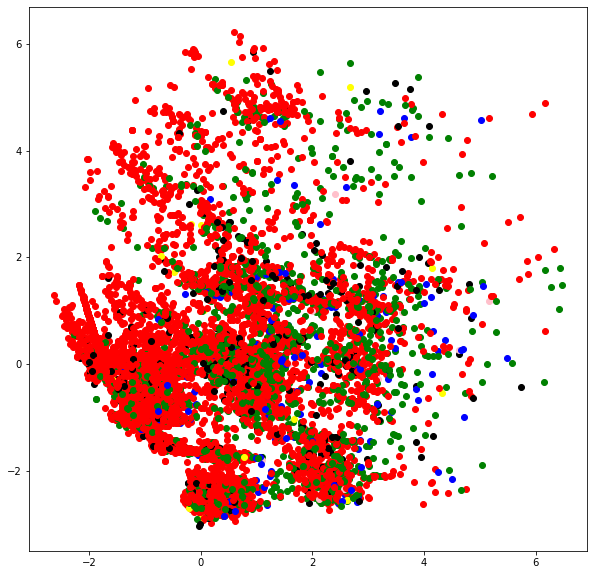

In [114]:
y = condition_
plt.figure(figsize=(10,10))
for i in range(len(X_pca)):
  plt.scatter(X_pca[i, 0], X_pca[i, 1], c = 'red' if y.values[i] == 'excellent' else 'blue' if y.values[i] == 'fair' else 'green' if y.values[i] == 'good'  else 'black' if y.values[i] == 'like new' else 'yellow' if y.values[i] == 'new' else 'pink' )

In [77]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_stand)
X = X_pca
y = condition_
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

6356 2724


In [78]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
knn.fit(X_test, y_test)
y_train_predict = knn.predict(X_train)
y_test_predict = knn.predict(X_test)
err_train = np.mean(y_train != y_train_predict)
err_test = np.mean(y_test != y_test_predict)

print(err_train, err_test)

0.25629326620516046 0.16740088105726872


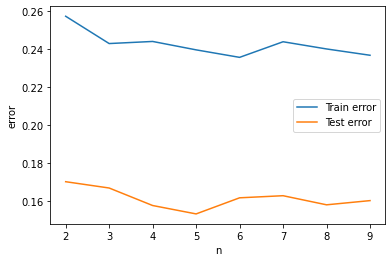

0.2355254877281309 6
0.15345080763582966 5


In [79]:
from sklearn.model_selection import train_test_split
err_train_list = []
err_test_list = []
for n_comp in range(2, 10):
    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(data_stand)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.3, random_state = 42)
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, y_train)
    knn.fit(X_test, y_test)
    y_train_predict = knn.predict(X_train)
    y_test_predict = knn.predict(X_test)
    err_train = np.mean(y_train != y_train_predict)
    err_test = np.mean(y_test != y_test_predict)
    
    err_train_list.append(err_train)
    err_test_list.append(err_test)
    
plt.plot(range(2, 10), err_train_list, label="Train error")
plt.plot(range(2, 10), err_test_list, label="Test error")
plt.xlabel('n')
plt.ylabel('error')
plt.legend()
plt.show()
print(min(err_train_list), 2 + err_train_list.index(min(err_train_list)))
print(min(err_test_list), 2 + err_test_list.index(min(err_test_list)))

## 7. Применение LDA

In [80]:
from sklearn import discriminant_analysis
lda_model = discriminant_analysis.LinearDiscriminantAnalysis()
X = data_stand
y = condition_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)  
    
N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print(N_train, N_test)


lda_model.fit(X_train, y_train)
y_pred = lda_model.predict(X_train)
y_test_pred = lda_model.predict(X_test)
print (np.mean(y_train != y_pred))
print (np.mean(y_test != y_test_pred))

6356 2724
0.24968533668974197
0.2448604992657856


In [98]:
from sklearn import neighbors
err_train = []
err_test = []
k_range = range(2, 10)
for k in k_range:
    knn_model = neighbors.KNeighborsClassifier(n_neighbors = k)
    knn_model.fit(X_train, y_train)
    knn_model.fit(X_test, y_test)
    y_pred      = knn_model.predict(X_train)
    y_test_pred = knn_model.predict(X_test)
    err_train.append(np.mean(y_train != y_pred))
    err_test.append(np.mean(y_test != y_test_pred))
    

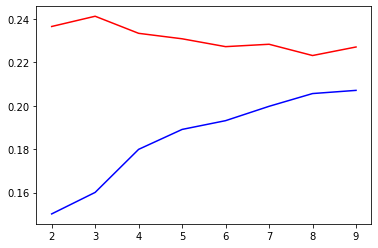

In [99]:

plt.plot(k_range, err_train, 'r')
plt.plot(k_range, err_test, 'b')

In [100]:
print (err_train[3], err_test[3])

0.23080553807426055 0.18906020558002937


In [86]:
condition_.sample(100)

287703    excellent
132119    excellent
214547    excellent
204452    excellent
7037       like new
            ...    
420514         fair
198282    excellent
335465    excellent
227268         good
106736    excellent
Name: condition, Length: 100, dtype: category
Categories (6, object): ['excellent', 'fair', 'good', 'like new', 'new', 'salvage']